In [4]:
################### #
# Attach packages ----
################### #
library(tidyverse)
library(tidymodels)
library(xgboost)
library(readxl)
library(writexl)
library(data.table)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──

✔ broom     0.7.4      ✔ recipes   0.1.15
✔ dials     0.0.9      ✔ rsample   0.0.9 
✔ infer     0.5.4      ✔ tune      0.1.3 
✔ modeldata 0.1.0      ✔ workflows 0.2.2 
✔ parsnip   0.1.5      ✔ yardstick 0.0.8 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::

In [5]:
#################### #
# Read data and mutate: ----
# Include lat, long and municipalities in data set 
# - Keep only the 220 most common municipalities in the datase
#################### #

houses_raw <- read_excel("temp/houses.xlsx")

houses <- houses_raw %>%
  select(id, sqm, expense, tot_price, lat, lng, kommune_name) %>%
  mutate(kommune_factor = fct_lump_n(kommune_name, 220) %>% as.integer()) 

In [6]:
################## #
# Split data using the rsample package ----
# Set seed in order to make the analysis reproducible 
################### #
set.seed(42)

split <- initial_split(houses, prop = 3/4)
train_raw <- training(split)
test_raw  <- testing(split)

train <- train_raw %>%
  select(-kommune_name, -id)

test <- test_raw %>%
  select(-kommune_name, -id)

In [124]:
################### #
# Create a xgboost model ----
################### #

model <- boost_tree(trees = 350) %>%
  set_mode("regression") %>% 
  set_engine("xgboost") %>% 
  fit(tot_price ~ ., data = train)

In [128]:
################### #
# View summary of the prediction ----
# Use the package yardstick to get evaluation of the model
################### #

model_preds <- 
  predict(model, test) %>% 
  bind_cols(test_raw) %>% 
  rename(estimate     = .pred, 
         truth        = tot_price) %>%
  mutate(abs_dev      = abs(truth - estimate),
         abs_dev_perc = abs_dev/truth)

mape(model_preds, truth, estimate)

estimate,id,sqm,expense,truth,lat,lng,kommune_name,kommune_factor,abs_dev,abs_dev_perc
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
3549446,10002,66,5147,3275086,59.94381,10.81159,Oslo,141,274360.0,0.08377185
3419480,10007,33,3559,3035761,59.94471,10.77751,Oslo,141,383719.0,0.12639961
3788966,10009,244,0,2350000,63.10960,7.72550,Kristiansund,92,1438966.2,0.61232606
7256960,10016,85,4060,6999081,59.92768,10.72269,Oslo,141,257878.5,0.03684462
1974116,10023,32,1573,2090000,63.40182,10.36100,Trondheim,206,115884.5,0.05544713
3612661,10025,61,3243,3402000,59.91651,10.81143,Oslo,141,210661.0,0.06192269


sqm,expense,tot_price,lat,lng,kommune_factor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
66,5147,3275086,59.94381,10.81159,141
33,3559,3035761,59.94471,10.77751,141
244,0,2350000,63.10960,7.72550,92
85,4060,6999081,59.92768,10.72269,141
32,1573,2090000,63.40182,10.36100,206
61,3243,3402000,59.91651,10.81143,141


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mape,standard,24.98679


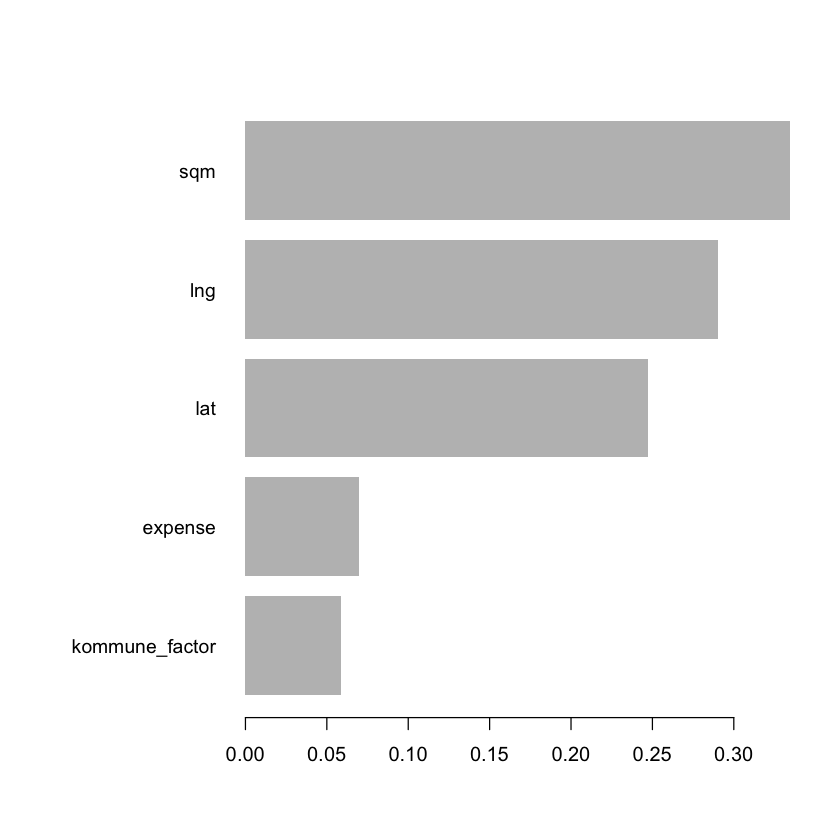

In [6]:
################### #
# Show importance plot of the model ----
# Using the package xgboost
################### #

xgb.importance(model = model$fit) %>% 
  xgb.plot.importance()

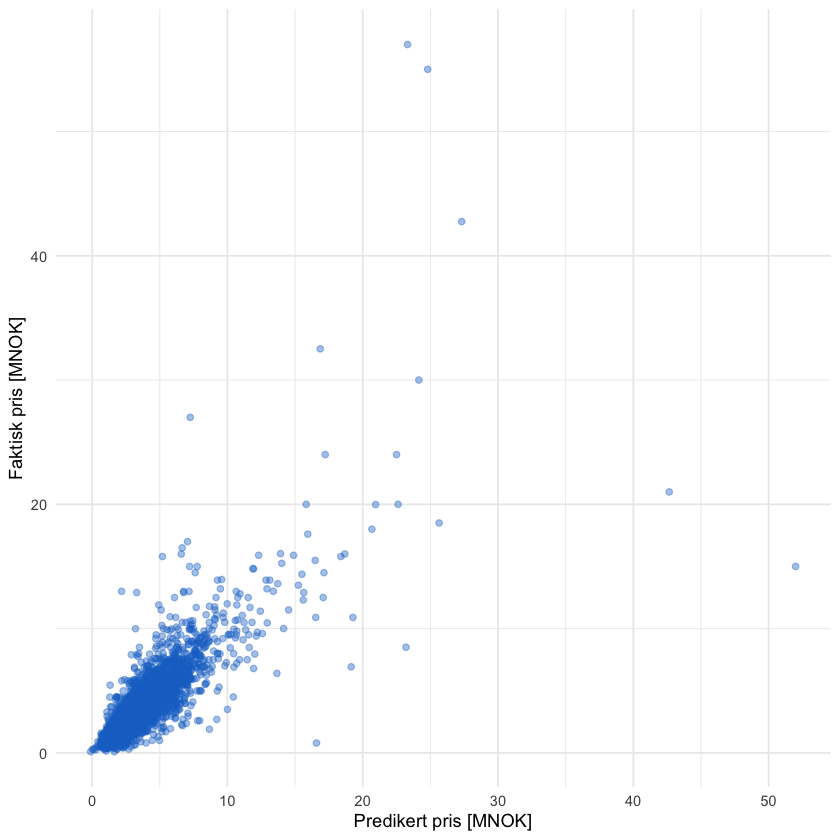

In [7]:
##################################### #
# Plot predictions ----
##################################### #
# Truth vs estimation
model_preds %>% 
  ggplot(aes(x = estimate/1000000, y = truth/1000000)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(x = "Predikert pris [MNOK]",
       y = "Faktisk pris [MNOK]") +
  theme_minimal()

Warning message:
“Removed 6 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


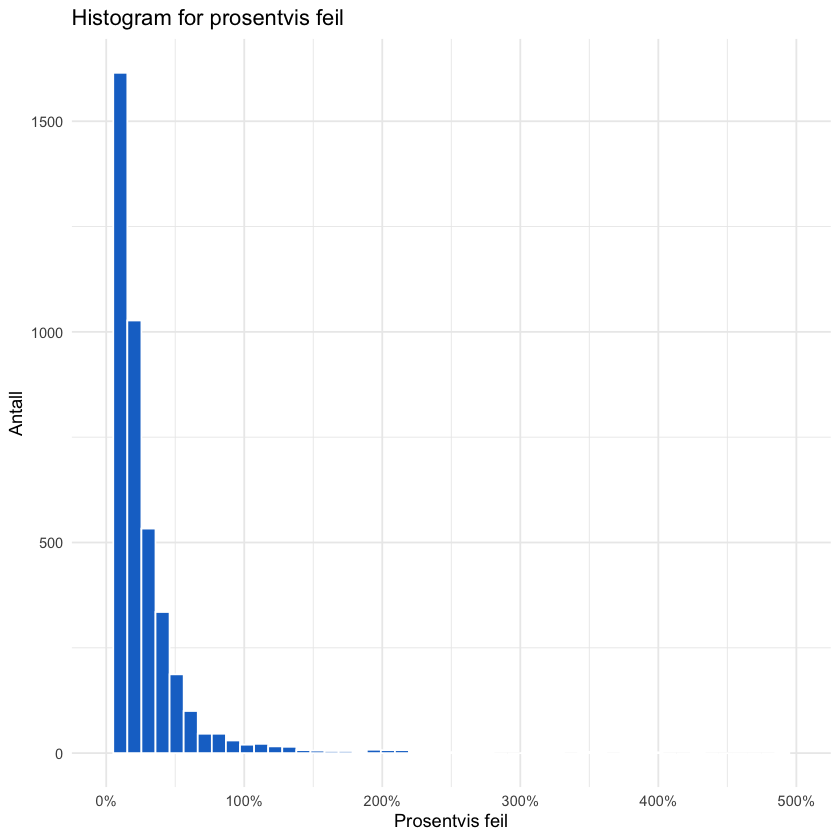

In [8]:
#Histogram of percentage error
model_preds %>%
  ggplot(aes(abs_dev_perc)) + 
  geom_histogram(fill = "dodgerblue3", color = "white", bins=50) +
  labs(title = "Histogram for prosentvis feil",
       x     = "Prosentvis feil",
       y     = "Antall") +
  scale_x_continuous(limits = c(0,5), labels = scales::percent) +
  theme_minimal()

Warning message:
“Removed 8 rows containing missing values (geom_point).”


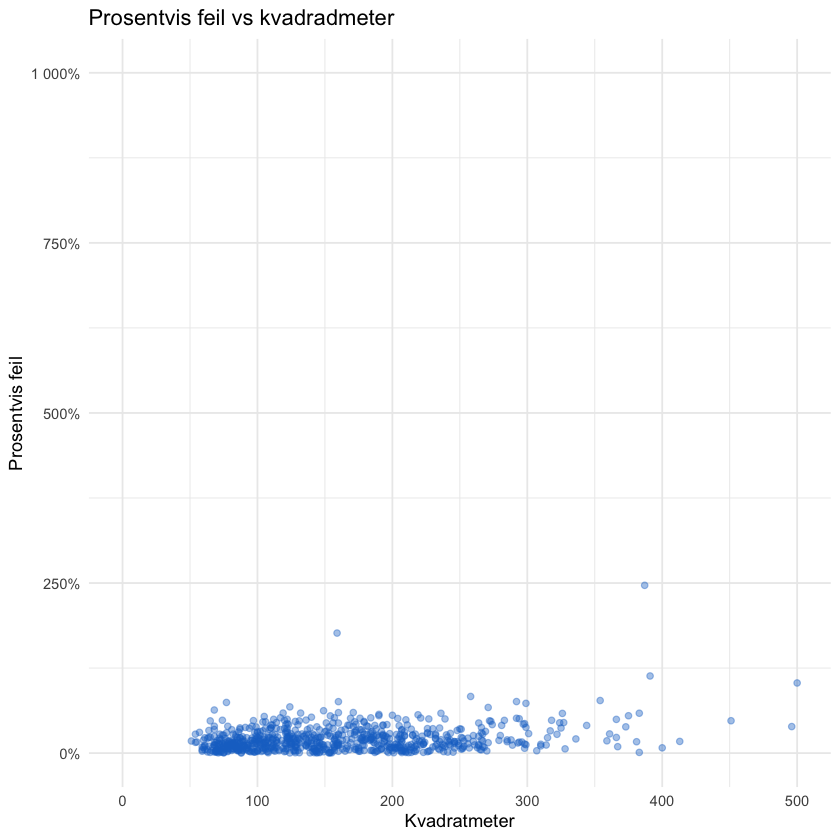

In [9]:
#Plot of abs_dev_perc by sqm (filter by total value > 5 million) 
model_preds %>%
  filter(truth > 5000000) %>%
  ggplot(aes(x = sqm, y = abs_dev_perc)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(title = "Prosentvis feil vs kvadradmeter",
       x     = "Kvadratmeter",
       y     = "Prosentvis feil") +
  scale_y_continuous(limits = c(0, 10), labels = scales::percent) +
  xlim(0, 500) +
  theme_minimal()

Warning message:
“Removed 2 rows containing missing values (geom_point).”


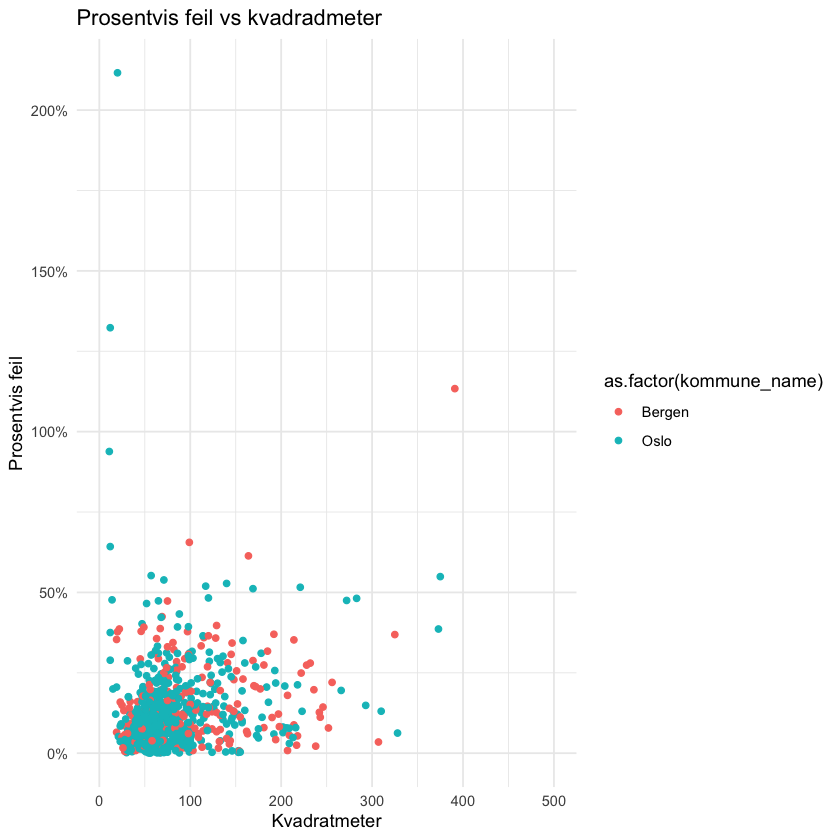

In [10]:
# Plot of abs_dev_perc by sqm (for Troms? and Bod?)
model_preds %>%
  filter(kommune_name == "Oslo" | kommune_name == "Bergen") %>%
  ggplot(aes(x = sqm, y = abs_dev_perc, color = as.factor(kommune_name))) +
  geom_point() +
  labs(title = "Prosentvis feil vs kvadradmeter",
       x     = "Kvadratmeter",
       y     = "Prosentvis feil") +
  scale_y_continuous(labels = scales::percent) + 
  xlim(0, 500) +
  theme_minimal() 

In [11]:
################### #
# Write prediction data to excel ----
################### #

write_xlsx(model_preds, "temp/predictions.xlsx")

# Using agtboost by Berent Lunde

In [7]:
library(agtboost)

In [8]:
set.seed(15312323)
train = data.frame(train)
test = data.frame(test)

X = train[, -which(colnames(train) == "tot_price")]
y = train[, which(colnames(train) == "tot_price")]

model = gbt.train(y = as.matrix(y), x = as.matrix(X), 
                 loss_function = "mse", verbose = 100)


it: 1  |  n-leaves: 15  |  tr loss: 6.304e+12  |  gen loss: 6.308e+12
it: 100  |  n-leaves: 19  |  tr loss: 3.341e+12  |  gen loss: 3.556e+12
it: 200  |  n-leaves: 29  |  tr loss: 2.065e+12  |  gen loss: 2.377e+12
it: 300  |  n-leaves: 62  |  tr loss: 1.55e+12  |  gen loss: 1.928e+12
it: 400  |  n-leaves: 19  |  tr loss: 1.288e+12  |  gen loss: 1.72e+12
it: 500  |  n-leaves: 12  |  tr loss: 1.181e+12  |  gen loss: 1.642e+12
it: 600  |  n-leaves: 11  |  tr loss: 1.135e+12  |  gen loss: 1.611e+12


In [9]:
X_test = test[, -which(colnames(test) == "tot_price")]
y_test = test[, which(colnames(test) == "tot_price")]

pred = predict(model, as.matrix(X_test))


In [11]:
mse = mean((pred - y_test)^2)
mse

[1] 2.028765e+12

sqm            lng            lat        expense kommune_factor 
     33.985849      27.965003      24.578501       7.784482       5.686165

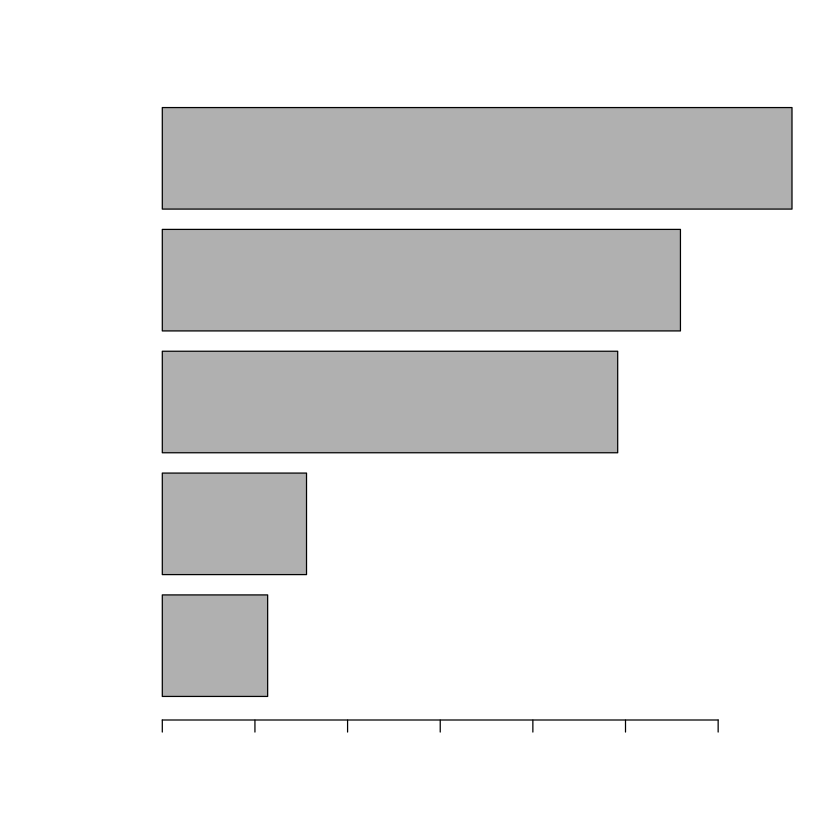

In [15]:
gbt.importance(colnames(X), model)

In [22]:
model_preds <- 
  predict(model, as.matrix(X_test)) %>% 
  bind_cols(test_raw) %>% 
  rename(estimate     = "...1", 
         truth        = tot_price) %>%
  mutate(abs_dev      = abs(truth - estimate),
         abs_dev_perc = abs_dev/truth)

New names:
* NA -> ...1



In [23]:
mape(model_preds, truth, estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mape,standard,28.61784


In [24]:
##################################### #
# Plot predictions ----
##################################### #
# Truth vs estimation
model_preds %>% 
  ggplot(aes(x = estimate/1000000, y = truth/1000000)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(x = "Predicted price [MNOK]",
       y = "True price [MNOK]") +
  theme_minimal()

ERROR: Error in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : polygon edge not found


plot without title

Warning message:
“Removed 11 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


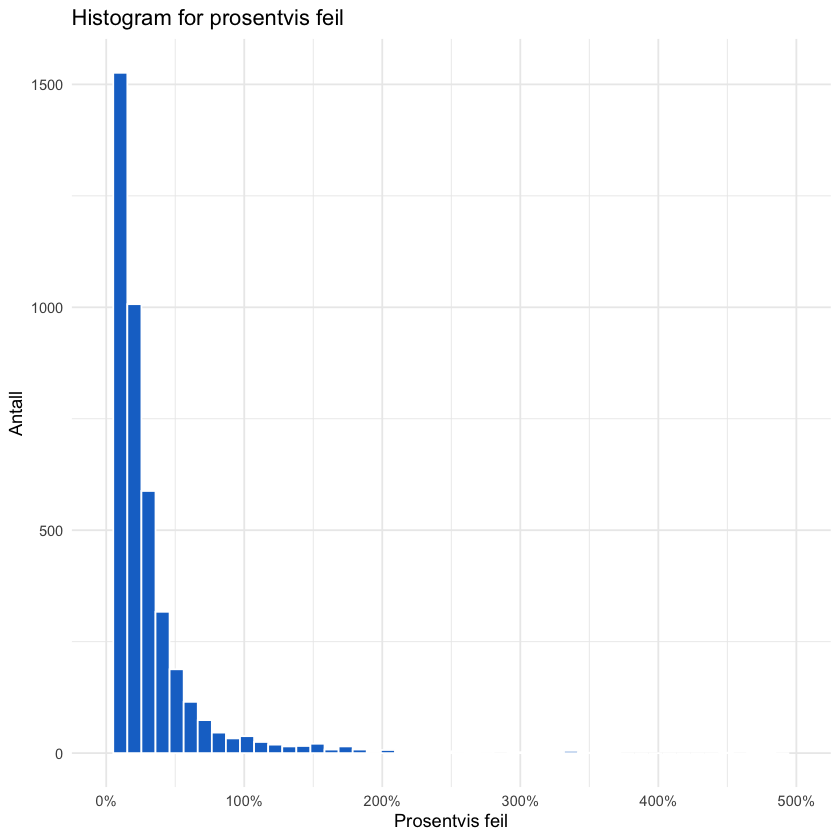

In [144]:
#Histogram of percentage error
model_preds %>%
  ggplot(aes(abs_dev_perc)) + 
  geom_histogram(fill = "dodgerblue3", color = "white", bins=50) +
  labs(title = "Histogram for prosentvis feil",
       x     = "Prosentvis feil",
       y     = "Antall") +
  scale_x_continuous(limits = c(0,5), labels = scales::percent) +
  theme_minimal()

Warning message:
“Removed 8 rows containing missing values (geom_point).”


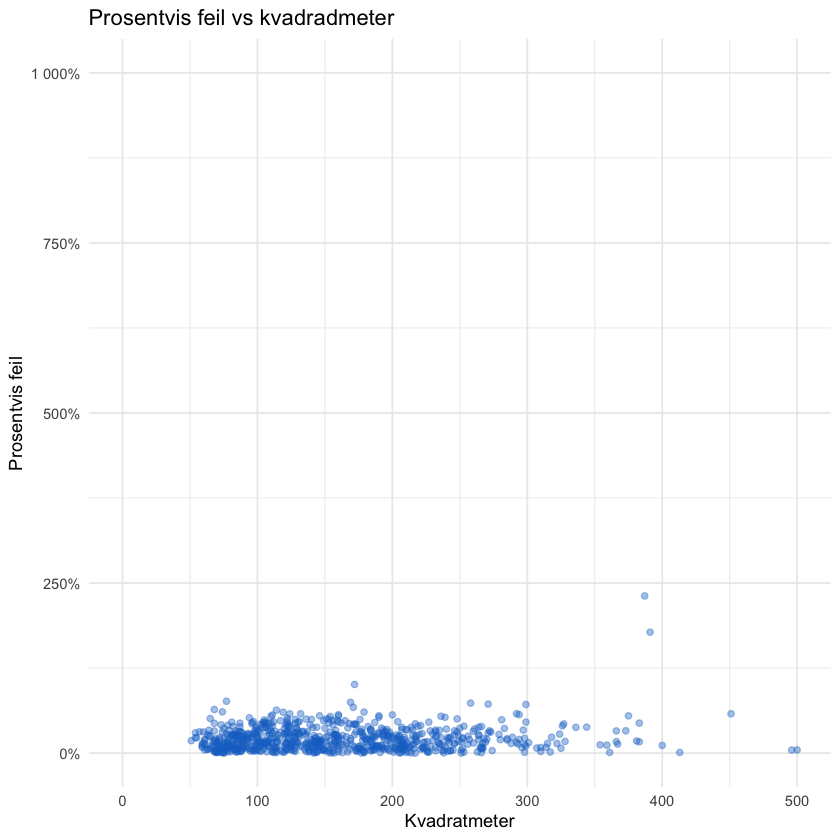

In [145]:
#Plot of abs_dev_perc by sqm (filter by total value > 5 million) 
model_preds %>%
  filter(truth > 5000000) %>%
  ggplot(aes(x = sqm, y = abs_dev_perc)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(title = "Prosentvis feil vs kvadradmeter",
       x     = "Kvadratmeter",
       y     = "Prosentvis feil") +
  scale_y_continuous(limits = c(0, 10), labels = scales::percent) +
  xlim(0, 500) +
  theme_minimal()

Warning message:
“Removed 2 rows containing missing values (geom_point).”


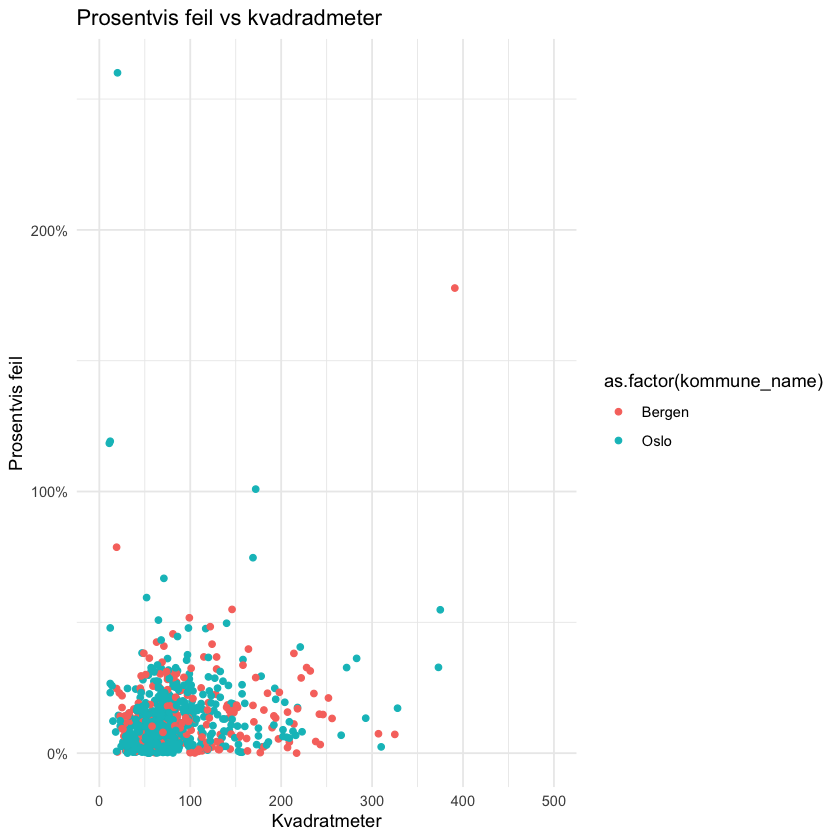

In [146]:
# Plot of abs_dev_perc by sqm (for Troms? and Bod?)
model_preds %>%
  filter(kommune_name == "Oslo" | kommune_name == "Bergen") %>%
  ggplot(aes(x = sqm, y = abs_dev_perc, color = as.factor(kommune_name))) +
  geom_point() +
  labs(title = "Prosentvis feil vs kvadradmeter",
       x     = "Kvadratmeter",
       y     = "Prosentvis feil") +
  scale_y_continuous(labels = scales::percent) + 
  xlim(0, 500) +
  theme_minimal() 

## Trying to tune an XGboost model

In [44]:
labels = train$tot_price
ts_label = test$tot_price

train = as.matrix(data.frame(train))
test = as.matrix(data.frame(test))

In [47]:
dtrain <- xgb.DMatrix(data = train, label = labels) 
dtest <- xgb.DMatrix(data = test, label=ts_label)

Class 'xgb.DMatrix' <externalptr> 
 - attr(*, ".Dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:6] "sqm" "expense" "tot_price" "lat" ...


ERROR: Error in xgb.DMatrix(dtrain): xgb.DMatrix does not support construction from externalptr


In [58]:
nfold = 5
set.seed(123321)
params = list(booster = "gbtree", objective = "reg:linear", 
               eta=0.3, gamma=0, max_depth=6, min_child_weight=1, 
               subsample=1, colsample_bytree=1)

xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 600, 
                 nfold = nfold, showsd = T, stratified = T, 
                 print.every.n = 10, early.stop.round = 20, maximize = F)

Warning message:
“'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated").”
Warning message:
“'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated").”


[19:53:32] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:33] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:33] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:33] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:34] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:3105684.550000+27595.218915	test-rmse:3114843.900000+125027.174791 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[11]	train-rmse:148626.259375+10660.132061	test-rmse:235520.928125+213929.400556 
[21]	train-rmse:31813.667969+2762.394192	te

In [59]:
# Here we find the number of trees that provides the best test-rmse and the test-rmse for that model
xgbcv$best_iteration; min(xgbcv$evaluation_log$test_rmse_mean)


[1] 506

[1] 178708.8

In [70]:
xgb1 <- xgb.train (params = params, data = dtrain, nrounds = 506, 
                   watchlist = list(val=dtest,train=dtrain), print.every.n = 20, 
                   early.stop.round = 10, maximize = F , eval_metric = "rmse")


Warning message:
“'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated").”
Warning message:
“'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated").”


[20:14:53] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:53] WARNING: amalgamation/../src/learner.cc:541: 
Parameters: { early_stop_round, print_every_n } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	val-rmse:3116251.000000	train-rmse:3104667.750000 
Multiple eval metrics are present. Will use train_rmse for early stopping.
Will train until train_rmse hasn't improved in 10 rounds.

[21]	val-rmse:227318.140625	train-rmse:49195.050781 
[41]	val-rmse:225784.328125	train-rmse:34812.789062 
[61]	val-rmse:224554.765625	train-rmse:26299.806641 
[81]	val-rmse:223688.703125	train-rmse:19756.148438 
[101]	val-rmse:223552.546875	train-rmse:15859.274414 
[121]	val-rmse:223120.984375	train-rmse:12561.202

Above we see that the difference in train-rmse and test-rmse is very large, therefor we will regularise the model and see which results we get.

In [102]:
set.seed(43341)
params = list(booster = "gbtree", objective = "reg:linear", 
               eta=0.3, gamma=10, max_depth=6, min_child_weight=1, 
               subsample=1, colsample_bytree=1)

xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 600, 
                 nfold = nfold, showsd = T, stratified = T, 
                 print.every.n = 100, early.stop.round = 20, maximize = F)

Warning message:
“'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated").”
Warning message:
“'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated").”


[08:22:06] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:06] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:06] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:06] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:06] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:3107470.550000+26916.834339	test-rmse:3111425.950000+122025.733884 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[11]	train-rmse:154174.615625+11498.902271	test-rmse:249091.918750+182124.820515 
[21]	train-rmse:51279.804688+2022.303234	te

In [103]:
# Here we find the number of trees that provides the best test-rmse and the test-rmse for that model
xgbcv$best_iteration; min(xgbcv$evaluation_log$test_rmse_mean)

[1] 390

[1] 176836.8

In [109]:
set.seed(441)

params = list(booster = "gbtree", objective = "reg:linear", 
               eta=0.3, gamma=100, max_depth=2, min_child_weight=1, 
               subsample=1, colsample_bytree=1)

xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 1000, 
                 nfold = nfold, showsd = T, stratified = T, 
                 print.every.n = 100, early.stop.round = 20, maximize = F)

Warning message:
“'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated").”
Warning message:
“'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated").”


[08:28:19] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:19] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:19] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:19] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:19] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:3176851.550000+12077.850803	test-rmse:3178007.650000+65298.892607 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[101]	train-rmse:71950.843750+844.401113	test-rmse:211406.896875+152551.800989 
[201]	train-rmse:37048.881250+879.707013	test-

In [107]:
set.seed(441)

params = list(booster = "gbtree", objective = "reg:linear", 
               eta=0.3, gamma=10000, max_depth=2, min_child_weight=1, 
               subsample=1, colsample_bytree=1)

xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 1000, 
                 nfold = nfold, showsd = T, stratified = T, 
                 print.every.n = 100, early.stop.round = 20, maximize = F)

Warning message:
“'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated").”
Warning message:
“'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated").”


[08:27:14] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:27:14] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:27:14] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:27:14] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:27:14] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:3176851.550000+12077.850803	test-rmse:3178007.700000+65298.957364 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[101]	train-rmse:71950.843750+844.401113	test-rmse:211406.895312+152551.802046 
[201]	train-rmse:37048.881250+879.707013	test-

In [110]:
set.seed(44531)

params = list(booster = "gbtree", objective = "reg:linear", 
               eta=0.3, gamma=10000, max_depth=2, min_child_weight=1, 
               subsample=1, colsample_bytree=1)

xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 1000, 
                 nfold = nfold, showsd = T, stratified = T, 
                 print.every.n = 100, early.stop.round = 20, maximize = F)

Warning message:
“'print.every.n' is deprecated.
Use 'print_every_n' instead.
See help("Deprecated") and help("xgboost-deprecated").”
Warning message:
“'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated").”


[08:28:43] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:43] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:43] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:43] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:43] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:3308618.400000+151791.674746	test-rmse:3308699.000000+300959.304861 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[101]	train-rmse:135077.012500+23755.267557	test-rmse:276860.809375+110365.091501 
[201]	train-rmse:81951.064063+13116.25299

In [ ]:
# Initialize values 

trees = 30000
grid = expand.grid(
  shrinkage = c(0.001, 0.005, 0.01, 0.05), splits = c(1, 2, 3),
  optimal_trees = 0, # To store results 
  min_cv_err = 0) # To store results

for (i in 1:dim(grid)[1]) { 
  set.seed(123)
  # Train the model
  
  
  grid$optimal_trees[i] = which.min(tune_model$cv.error)
  grid$min_cv_err[i] = min(tune_model$cv.error) 
}

